# Spectral and temporal modifications Lab
# BITTENCOURT Gabriela
# Santiago ??

Template from *From R. Badeau and G. Richard (with help from P. Vernhet), MAJ:2019*

**python version : 3.6**

In [1]:
import os, sys, wave, struct

import numpy as np
import pyaudio
import pandas as pd
import matplotlib.pyplot as plt

from copy import deepcopy
from math import ceil
from math import floor
from scipy import signal

from scipy.io.wavfile import write

## Functions

In [2]:
def load_sound(file):
    return wave.open(file, 'rb')


def play_sound(file, chunk = 1024):
    """
    Script from PyAudio doc
    """
    wf = load_sound(file)
    p = pyaudio.PyAudio()
    stream = p.open(format=p.get_format_from_width(wf.getsampwidth()),
                    channels=wf.getnchannels(),
                    rate=wf.getframerate(),
                    output=True)
    data = wf.readframes(chunk)

    while data:
        stream.write(data)
        data = wf.readframes(chunk )

    stream.stop_stream()
    stream.close()
    p.terminate()
    
    
def plot_sound(data, times, name='default_name', save=False):
    plt.figure(figsize=(30, 4))
    plt.fill_between(times, data)
    plt.xlim(times[0], times[-1])
    plt.xlabel('time (s)')
    plt.ylabel('amplitude')
    if save:
        plt.savefig(name+'.png', dpi=100)
    plt.show()

def nextpow2(x):
    assert x>0
    p = ceil(np.log2(x))
    x_ = 2**p
    assert 2**(p-1) < x <= x_
    return x_

def period(x, Fs, Pmin=1/300, Pmax=1/80, seuil=0.7) :
    # [P,voiced] = period(x,Fs,Pmin,Pmax,seuil);
    # If voiced = 1, P is the period signal x expressed in number of samples
    # If voiced = 0, P is equal to 10ms.Fs

    x = x - np.mean(x)
    N = len(x)

    Nmin = np.ceil(Pmin*Fs).astype(int)
    Nmax = 1 + np.floor(Pmax*Fs).astype(int)
    Nmax = np.min([Nmax,N])

    Nfft = nextpow2(2*N-1)
    X = np.fft.fft(x, n=Nfft)
    S = X * np.conj(X) / N
    r = np.real(np.fft.ifft(S))

    rmax = np.max(r[Nmin:Nmax])
    I = np.argmax(r[Nmin:Nmax])
    P = I+Nmin
    corr = (rmax/r[0]) * (N/(N-P))
    voiced = corr > seuil
    if not(voiced):
        P = np.round(10e-3*Fs)

    return P,voiced

## 0 - Reading and playing .wav file

Choose the name of sound for the rest of the notebook. Sounds are assumed to be set in a folder named 'sons_mutltipitch' (same directory as notebook).

In [3]:
data_path = os.getcwd()
filename = 'aeiou.wav'
sound = os.path.join(data_path, filename) 

### **Using wave**

In [4]:
wavefile = load_sound(sound)
print(wavefile.getparams())

_wave_params(nchannels=1, sampwidth=2, framerate=11025, nframes=59964, comptype='NONE', compname='not compressed')


In [5]:
play = True
if play :
    play_sound(sound)

In [6]:
Fs = int(wavefile.getframerate())
num_samples = int(wavefile.getnframes())
data = wavefile.readframes(num_samples)
data = struct.unpack('{n}h'.format(n=num_samples), data)
s = np.array(data)

In [7]:
timestep = 1/float(Fs)
times = np.arange(len(s))*timestep

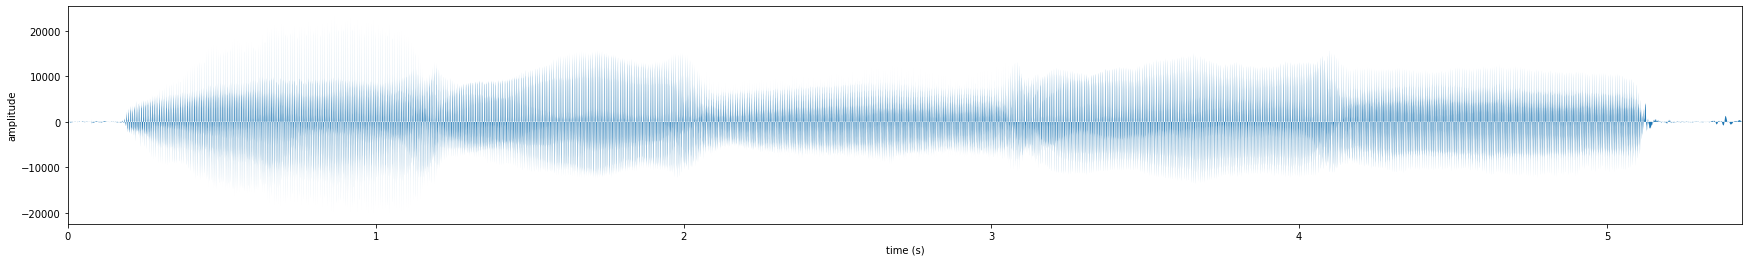

In [8]:
plot_sound(s, times)

In [9]:
def write_n_play_sound(filename, x) :
    write(filename, Fs, np.array(np.real(x), dtype=np.int16))
    sound = os.path.join(data_path, filename)
    if play :
        play_sound(sound)

## 1 - Extraction of the analysis marks

In [10]:
def AnalysisPichMarks(s, Fs) :
    
    ta = np.array([0])
    Pa = np.ceil(np.array([0.01*Fs])).astype(int)
    voiced = np.array([0])
    
    while ( ta[-1]+2.5*Pa[-1] <= len(s) ) : # while there are frames
        
        # Extracting x -> start: ta(n-1), duration: 2.5*Pa(n-1)
        t0 = int(ta[-1])
        tf = int(ta[-1] + 2.5*Pa[-1])
        x = s[t0:tf]
        
        # Computation Pa(n) and voiced(n)
        Pa     = np.append(Pa,    period(x, Fs)[0])
        voiced = np.append(voiced,period(x, Fs)[1])
        
        # Computation ta(n)
        ta = np.append(ta, ta[-1]+Pa[-1])

    A = np.array(([ta, voiced, Pa])).astype(int)
    return A

# A(0,:) = ta(n)
# A(1,:) = voiced(n)
# A(2,:) = Pa(n)
A = AnalysisPichMarks(s, Fs)

## 2 - Synthesis and modification of the temporal and spectral scales

In [11]:
# B(0,:) = ts(k)
# B(1,:) = n(k) = [0,1,2,...]
B = np.array([A[0], np.arange(A.shape[1])])

### 2.1 - Signal Synthesis

In [12]:
ta_filter = A[0][B[1]]
Pa_filter = A[2][B[1]]
ts = B[0]
    
# initialize y
#slod = ts[-1] + Pa[-1]
print(Pa_filter[-1])
#y = np.zeros(ts[-1] + Pa[-1])

110


In [13]:
def Synthesis(s, Fs, A, B) :
    
    # filter ta(A[0]), Pa(A[2]) to only the indices in n[k](B[1])
    ta_filter = A[0][B[1]]
    Pa_filter = A[2][B[1]]
    ts = B[0]
    
    # initialize y
    y = np.zeros(ts[-1] + Pa_filter[-1])
    
    for k in range(1,B.shape[1]):
        # extraction of x
        x = s[ ta_filter[k]-Pa_filter[k] : ta_filter[k]+Pa_filter[k]]
        # Hann window
        ws = signal.windows.hann(2*Pa_filter[k])
        # overlap-add
        y[ts[k]-Pa_filter[k] : ts[k]+Pa_filter[k]] += x*ws
    
    return y

y = Synthesis(s, Fs, A, B)

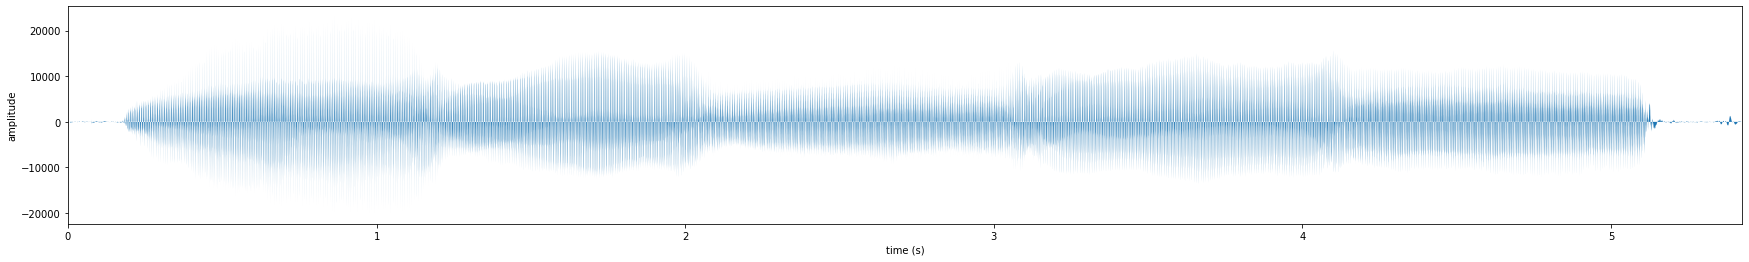

In [14]:
times = np.arange(len(y))*timestep
plot_sound(y, times)

In [15]:
# creates an audio file with the result
write_n_play_sound('perfect_reconstruction.wav', y)

### 2.2 - Modification of the temporal scale

In [16]:
def ChangeTimeScale(alpha,A,Fs) :
    ts = np.array([1])
    n  = np.array([0,1])
    
    while(floor(n[-1]) < A.shape[1]) :
        ts = np.append(ts, ts[-1] + A[2][floor(n[-1])])
        n  = np.append(n, n[-1]+1/alpha)
    
    B = np.array([ts, np.floor(n[:-1])]).astype(int)
    return B

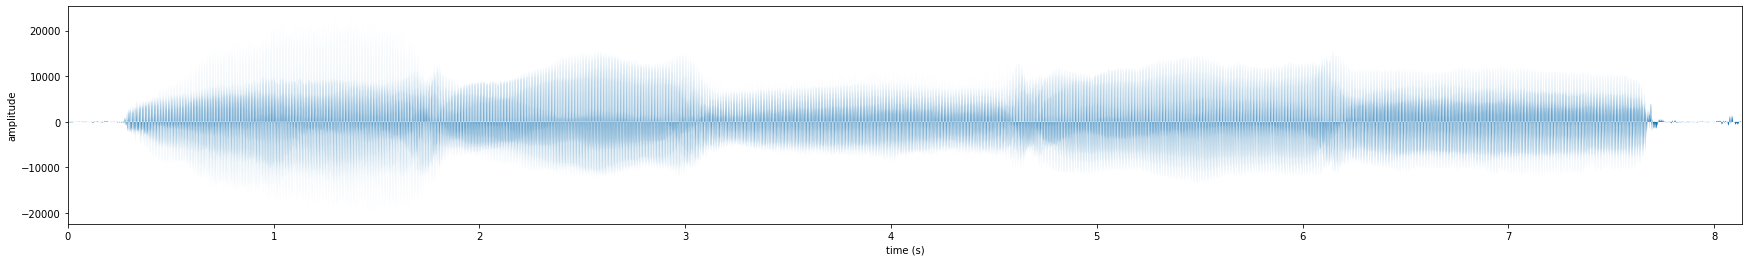

In [17]:
# time streching by 1.5
alpha = 1.5

B = ChangeTimeScale(alpha,A,Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_stretching.wav', y)

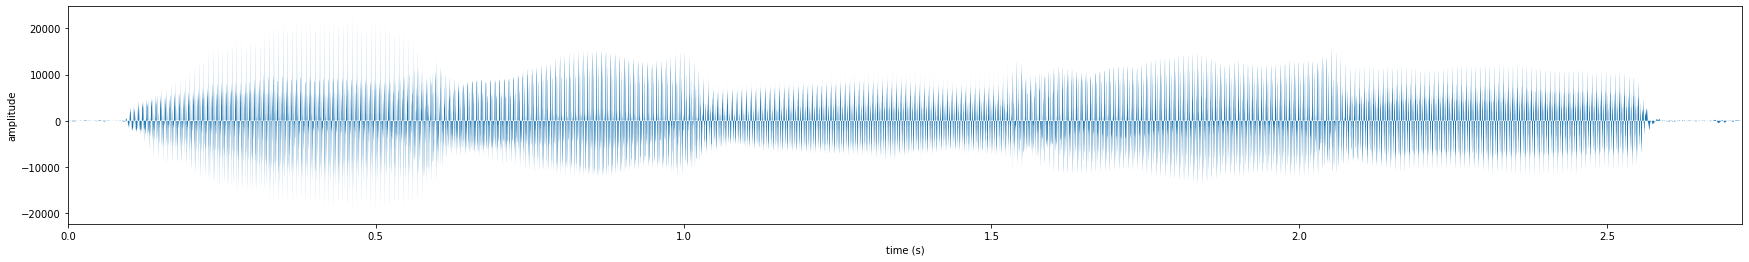

In [18]:
# time compressing by 0.5
alpha = 0.5

B = ChangeTimeScale(alpha,A,Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_compressing.wav', y)

### 2.3 - Modification of the spectral scale

In [19]:
def ChangePitchScale(beta, A, Fs) :
    ts = np.array([1])
    n  = np.array([0,1])
    
    scale = A[1]/beta
    scale[scale == 0] = 1
    
    while (floor(n[-1]) < A.shape[1]) :
        ts = np.append(ts, ts[-1] + scale[floor(n[-1])] * A[2][floor(n[-1])])
        n  = np.append(n, n[-1] + scale[floor(n[-1])])
    
    B = np.array([ts, np.floor(n[:-1])]).astype(int)
    return B

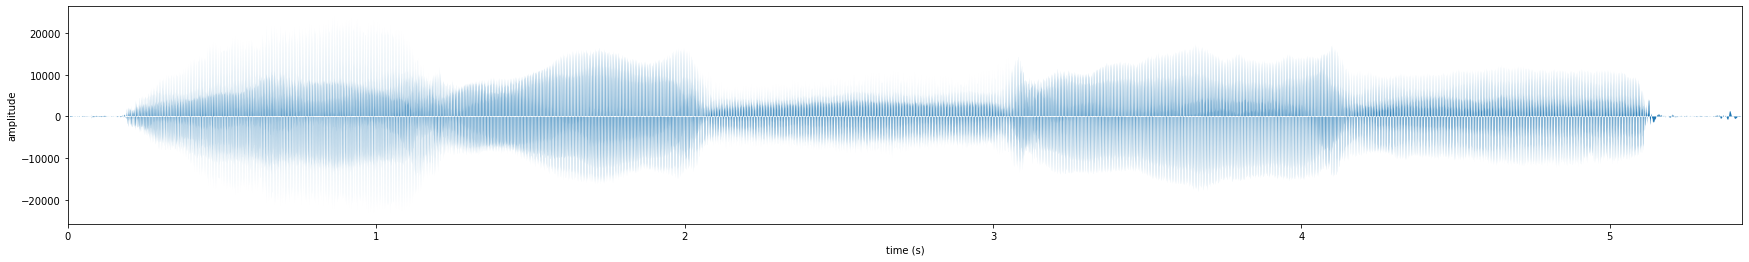

In [20]:
# pitch increasing
beta = 1.5

B = ChangePitchScale(beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('pitch_increase.wav', y)

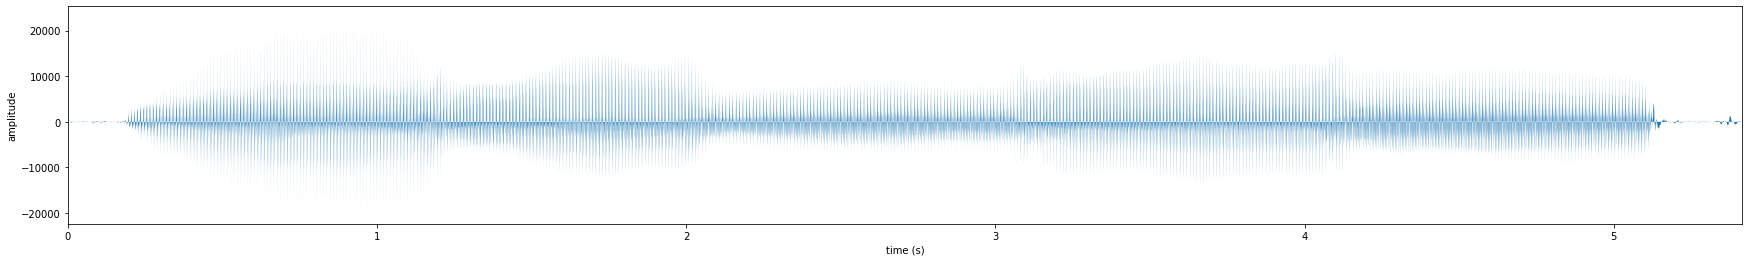

In [21]:
# pitch decreasing
beta = 0.7

B = ChangePitchScale(beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('pitch_decrease.wav', y)

### 2.4 - Joint modification of the temporal and spectral scales

In [22]:
def ChangeBothScales(alpha,beta,A,Fs) :
    ts = np.array([1])
    n  = np.array([0,1])
    
    scale = A[1]/beta
    scale[scale == 0] = 1
    
    while (floor(n[-1]) < A.shape[1]) :
        ts = np.append(ts, ts[-1] + scale[floor(n[-1])] * A[2][floor(n[-1])])
        n  = np.append(n, n[-1] + scale[floor(n[-1])]/alpha)
    
    B = np.array([ts, np.floor(n[:-1])]).astype(int)
    return B

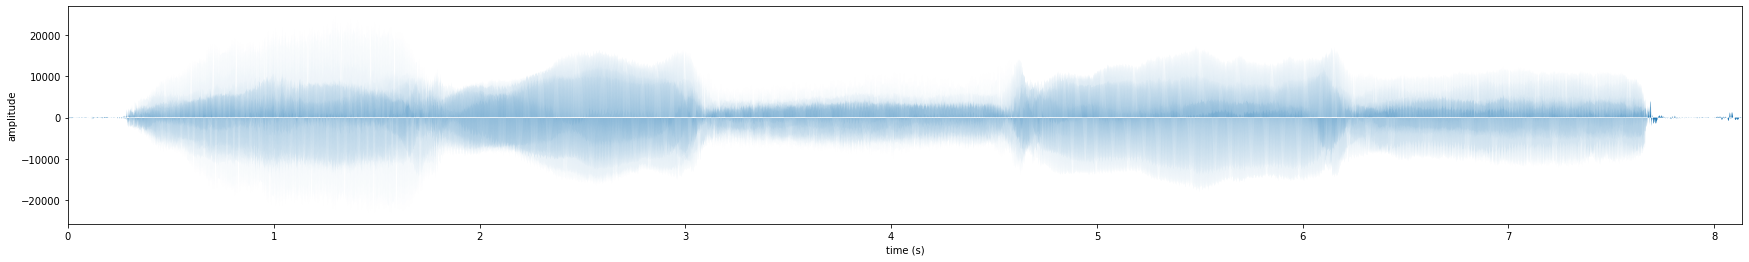

In [23]:
# time stretching and pitch increasing
alpha = 1.5
beta = 1.5

B = ChangeBothScales(alpha, beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_n_frequency_scale1.wav', y)

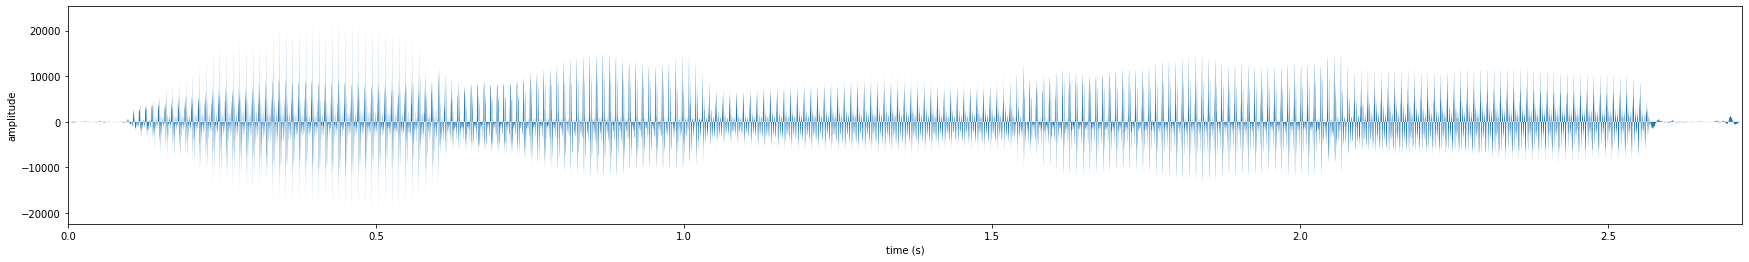

In [24]:
# time compressing and pitch decreasing
alpha = 0.5
beta = 0.7

B = ChangeBothScales(alpha, beta, A, Fs)
y = Synthesis(s, Fs, A, B)

times = np.arange(len(y))*timestep
plot_sound(y, times)

# creates an audio file with the result
write_n_play_sound('time_n_frequency_scale2.wav', y)